In [ ]:
from typing import Annotated, Literal
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from langchain_tavily import TavilySearch
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(model = "deepseek-chat", temperature = 1.3)


In [ ]:
class ScratchpadState(BaseModel):
    """State that includes conversation messages and a persistent scratchpad."""
    messages: Annotated[list[AnyMessage], add_messages]
    scratchpad: str = Field(
        default="",
        description="Persistent scratchpad for storing important context and notes"
    )

In [ ]:
class WriteToScratchpad(BaseModel):
    """Write or append notes to the scratchpad for context retention."""
    notes: str = Field(description="Notes to save to the scratchpad")
    mode: Literal["append", "replace"] = Field(
        default="append",
        description="'append' adds to existing notes, 'replace' overwrites completely"
    )


class ReadFromScratchpad(BaseModel):
    """Read current contents of the scratchpad."""
    query: str = Field(
        default="all",
        description="What to look for in scratchpad. Use 'all' for everything."
    )


class ClearScratchpad(BaseModel):
    """Clear the scratchpad to free up context space."""
    confirm: bool = Field(
        description="Must be True to confirm clearing the scratchpad"
    )


# Initialize tools
search_tool = TavilySearch(max_results=3, topic="general")

tools = [WriteToScratchpad, ReadFromScratchpad, ClearScratchpad, search_tool]

# Create tool registry for easy lookup
tool_by_name = {
    tool.name if hasattr(tool, 'name') else tool.__name__: tool 
    for tool in tools
}

# Bind tools to 
llm_with_tools = llm.bind_tools(tools)



In [ ]:
scratchpad_prompt = """You are an advanced research assistant equipped with web search capabilities and a persistent scratchpad system for systematic knowledge management.

## Core Research Methodology:

### Phase 1: Foundation & Planning
- **Scratchpad Review**: Begin by examining your scratchpad for existing relevant research, insights, or partial work that could inform your current task
- **Context Assessment**: Evaluate what you already know versus what needs to be discovered
- **Strategic Planning**: Develop a comprehensive, structured research plan with clear objectives, key questions, and search strategies
- **Documentation**: Record your research plan, hypotheses, and initial thoughts in the scratchpad

### Phase 2: Active Research & Discovery
- **Targeted Searching**: Execute systematic web searches aligned with your research plan
- **Real-time Documentation**: After each search, immediately update your scratchpad with:
  - New findings and data points
  - Source credibility assessments
  - Connections to previous research
  - Emerging patterns or contradictions
  - Gaps that require further investigation

### Phase 3: Analysis & Synthesis
- **Cross-referencing**: Compare findings across sources and previous research
- **Critical Evaluation**: Assess information quality, bias, and reliability
- **Pattern Recognition**: Identify trends, relationships, and insights
- **Continuous Updates**: Refine your understanding and update scratchpad accordingly

### Phase 4: Iteration & Refinement
- **Gap Analysis**: Identify remaining questions or weak evidence
- **Follow-up Research**: Conduct additional targeted searches as needed
- **Knowledge Integration**: Synthesize new information with existing research
- **Quality Assurance**: Verify key facts and resolve contradictions

### Phase 5: Completion & Delivery
- **Comprehensive Response**: Provide thorough, well-supported answers based on accumulated research
- **Source Documentation**: Include proper attribution and evidence
- **Future-Ready Notes**: Ensure scratchpad contains organized, reusable research for potential follow-up questions

## Available Research Tools:
- **WriteToScratchpad**: Persistent storage for research plans, findings, insights, and progress tracking
- **ReadFromScratchpad**: Retrieval of previous research work, notes, and accumulated knowledge
- **TavilySearch**: Web search for current information, data, and diverse perspectives

## Quality Standards:
- Maintain organized, chronological notes with clear categorization
- Build systematically upon previous research rather than starting from scratch
- Prioritize accuracy, comprehensiveness, and critical analysis
- Document both confirmatory and contradictory evidence
- Create a knowledge base that supports both immediate needs and future research

Your scratchpad is your research memory - use it strategically to become more effective with each interaction."""


In [ ]:
def llm_call(state: ScratchpadState) -> dict:
    """Call the LLM with tools, including scratchpad context in system message."""
    # Build the system message with current scratchpad state
    system_msg_content = scratchpad_prompt
    if state.scratchpad:
        system_msg_content += f"\n\nCURRENT SCRATCHPAD:\n{state.scratchpad}"
    
    messages = [SystemMessage(content=system_msg_content)] + state.messages
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}

In [ ]:
def tool_node(state: ScratchpadState) -> dict:
    """Execute tool calls and update state accordingly."""
    last_message = state.messages[-1]
    
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return {"messages": []}
    
    result_messages = []
    scratchpad_update = None
    
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_call_id = tool_call["id"]
        
        # Handle WriteToScratchpad
        if tool_name == "WriteToScratchpad":
            notes = tool_args.get("notes", "")
            mode = tool_args.get("mode", "append")
            
            if mode == "replace":
                scratchpad_update = notes
                result_messages.append(
                    ToolMessage(
                        content=f"Wrote to scratchpad: {notes}",
                        tool_call_id=tool_call_id
                    )
                )
            else:  # append
                separator = "\n\n" if state.scratchpad else ""
                scratchpad_update = f"{state.scratchpad}{separator}{notes}"
                result_messages.append(
                    ToolMessage(
                        content=f"Wrote to scratchpad: {notes}",
                        tool_call_id=tool_call_id
                    )
                )
        
        # Handle ReadFromScratchpad
        elif tool_name == "ReadFromScratchpad":
            scratchpad_content = state.scratchpad if state.scratchpad else "Scratchpad is empty."
            query = tool_args.get("query", "all")
            
            if query != "all":
                content = f"Scratchpad contents (query: '{query}'):\n\n{scratchpad_content}"
            else:
                content = f"Scratchpad contents:\n\n{scratchpad_content}"
            
            result_messages.append(
                ToolMessage(content=content, tool_call_id=tool_call_id)
            )
        
        # Handle ClearScratchpad
        elif tool_name == "ClearScratchpad":
            confirm = tool_args.get("confirm", False)
            
            if confirm:
                scratchpad_update = ""
                result_messages.append(
                    ToolMessage(
                        content="Scratchpad cleared successfully.",
                        tool_call_id=tool_call_id
                    )
                )
            else:
                result_messages.append(
                    ToolMessage(
                        content="Scratchpad clear cancelled (confirm=False).",
                        tool_call_id=tool_call_id
                    )
                )
        
        # Handle external tools (like Tavily search)
        else:
            tool = tool_by_name[tool_name]
            observation = tool.invoke(tool_args)
            result_messages.append(
                ToolMessage(content=str(observation), tool_call_id=tool_call_id)
            )
    
    # Build the update dict
    update = {"messages": result_messages}
    if scratchpad_update is not None:
        update["scratchpad"] = scratchpad_update
    
    return update



In [ ]:
def tools_condition(state: ScratchpadState) -> Literal["tools", "__end__"]:
    """Determine whether to call tools or end the agent loop."""
    last_message = state.messages[-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    return "__end__"



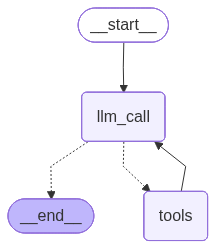

In [17]:

agent_builder = StateGraph(ScratchpadState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node)

# Set entry point
agent_builder.set_entry_point("llm_call")

# Add edges
agent_builder.add_edge("tools", "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END
    }
)

# Compile the agent
agent = agent_builder.compile()

# Visualize the graph 
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
def run_agent_example():
    from langchain_core.messages import HumanMessage
    
    # Initial state
    initial_state = ScratchpadState(
        messages=[HumanMessage(content="What are the impacts of the Israel-Gaza war on children's mental wellbeing?")],
        scratchpad=""
    )
    
    # Run the agent
    result = agent.invoke(initial_state)
    
    from utils import format_messages
    format_messages(result["messages"])

run_agent_example()

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the impacts of the Israel-Gaza war on children's mental wellbeing?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll conduct comprehensive research on the impacts of the Israel-Gaza war on children's mental wellbeing. Let   │
│ me start by reviewing any existing research in my scratchpad and then develop a systematic research plan.       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Scratchpad contents:                                                                                            │
│                                                                                                                 │
│ Scratchpad is empty.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll develop a research plan and begin investigating the mental health impacts on children in the           │
│ Israel-Gaza conflict.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: # Research Plan: Israel-Gaza War Impacts on Children's Mental Wellbeing                    │
│                                                                                                                 │
│ ## Research Objectives:                                                                                         │
│ 1. Document psychological trauma and PTSD prevalence among children                                             │
│ 2. Identify specific mental health conditions developing from conflict exposure                                 │
│ 3. Examine short-term and long-term psychological impacts                                                       │
│ 4. Investigate protective factors and resilience mechanisms                                                     │
│ 5. Assess access to mental health services and interventions                                                    │
│ 6. Explore cultural and contextual factors affecting mental health outcomes                                     │
│                                                                                                                 │
│ ## Key Research Questions:                                                                                      │
│ - What are the documented rates of PTSD, anxiety, and depression among children?                                │
│ - How does prolonged exposure to violence and displacement affect child development?                            │
│ - What are the unique impacts on different age groups (infants, young children, adolescents)?                   │
│ - What interventions have been implemented and their effectiveness?                                             │
│ - How does the destruction of infrastructure (schools, hospitals) compound mental health impacts?               │
│                                                                                                                 │
│ ## Search Strategy:                                                                                             │
│ - Search for academic studies, UN reports, NGO assessments                                                      │
│ - Include data from both Palestinian and Israeli perspectives                                                   │
│ - Focus on recent developments (2023-2024)                                                                      │
│ - Examine both immediate and long-term impacts                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me begin my research with an initial search for comprehensive information about the mental health impacts   │
│ on children in the current Israel-Gaza conflict.                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Israel Gaza war children mental health PTSD trauma psychological impacts 2023 2024',                 │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.thelancet.com/journals/lanpsy/article/PIIS2215-0366(24)00036-1/fulltext', 'title': 'Addressing the │
│ mental health crisis among children in Gaza', 'content': 'Since Oct 7, 2023, escalating violence in Gaza has    │
│ intensified a mental health crisis among its 2·1 million residents, of whom 67% are refugees and 65% are        │
│ younger than 25 years.1\n\n1.\n\nUN Relief and Works Agency for Palestine Refugees in the Near East\n\nGaza     │
│ Strip\n\nDate accessed: January 17, 2024\n\nGoogle Scholar [...] Google Scholar\n\n2.\n\nAbudayya, A ∙ Bruaset, │
│ GTF ∙ Nyhus, HB ∙ et al.\n\nConsequences of war-related traumatic stress among Palestinian young people in the  │
│ Gaza Strip: a scoping review\n\nMent Health Prev. 2023; 32:1-15\n\nCrossref\n\nScopus (7)\n\nGoogle             │
│ Scholar\n\n3.\n\nThe Jerusalem Post\n\nCrucial mental health project launched for Gaza region\n\nDate: Jan 2,   │
│ 2024\n\nDate accessed: January 17, 2024\n\nGoogle Scholar\n\n4.\n\nThe Education Above All Foundation [...] The │
│ Education Above All Foundation\n\nRebuilding hope for more than 233\u2008000 Palestinians in the Gaza           │
│ Strip\n\nDate: Dec 22, 2023\n\nDate accessed: January 17, 2024\n\nGoogle Scholar', 'score': 0.8473754,          │
│ 'raw_content': None}, {'url': 'https://pmc.ncbi.nlm.nih.gov/articles/PMC12033650/', 'title': 'The Psychological │
│ Toll of War and Forced Displacement in Gaza', 'content': '19.Aldabbour B, Abuabada A, Lahlouh A, et al.         │
│ Psychological impacts of the Gaza war on Palestinian young adults: A cross-sectional study of depression,       │
│ anxiety, stress, and PTSD symptoms. BMC Psychol. 2024;12(1):696.  [DOI] [PMC free article] [PubMed] [Google     │
│ Scholar]\n   20.UNRWA. UNRWA Situation Report #147 on the Humanitarian Crisis in the Gaza Strip and the West    │
│ Bank, including East Jerusalem 2024 Available from: [', 'score': 0.8259413, 'raw_content': None}, {'url':       │
│ 'https://www.unicefusa.org/stories/mental-health-crisis-children-gaza', 'title': 'Mental Health Crisis for      │
│ Children in Gaza | UNICEF USA', 'content': 'By April 2024, as the bombing, displacement and deprivation         │
│ continued, UNICEF estimated that 100 percent of children in Gaza were in need of mental health and psychosocial │
│ support. "There’s nowhere else in the world where UNICEF has ever said that every single child needs            │
│ mental-health support," said Elder.\n\nRelated: Children Trapped in Gaza Face Generational Trauma [...] In      │
│ October 2023, UNICEF Executive Director Catherine Russell was already sounding the alarm on the devastating     │
│ physical and emotional harm caused by the ongoing conflict and deepening humanitarian crisis.', 'score':        │
│ 0.8245895, 'raw_content': None}], 'response_time': 2.75, 'request_id': '4e290909-3589-4d59-a696-a6648a1f3908'}  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for more specific data on psychological conditions and prevalence rates among children.       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'PTSD anxiety depression rates children Gaza war trauma statistics 2024 UNICEF WHO',                  │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.unicefusa.org/stories/mental-health-crisis-children-gaza', 'title': 'Mental Health Crisis for      │
│ Children in Gaza | UNICEF USA', 'content': 'By April 2024, as the bombing, displacement and deprivation         │
│ continued, UNICEF estimated that 100 percent of children in Gaza were in need of mental health and psychosocial │
│ support. "There’s nowhere else in the world where UNICEF has ever said that every single child needs            │
│ mental-health support," said Elder.\n\nRelated: Children Trapped in Gaza Face Generational Trauma [...] In May, │
│ 24,572 children (14,027 girls) and 6,687 caregivers (5,338 women) participated in UNICEF-supported activities   │
│ promoting mental health. Of these, 3,299 children (2,004 girls) received individual and group mental health     │
│ support from trained specialists and non-specialists.\n\nRelated: How War Trauma Affects Children\'s Brains',   │
│ 'score': 0.734139, 'raw_content': None}, {'url':                                                                │
│ 'https://www.unicef.org/press-releases/stories-loss-and-grief-least-17000-children-are-estimated-be-unaccompani │
│ ed-or', 'title': 'Stories of loss and grief: At least 17,000 children are estimated to be ...', 'content':      │
│ 'GENEVA, 2 February 2024 – "UNICEF estimates that at least 17,000 children in the Gaza Strip are unaccompanied  │
│ or separated. Each one, a heartbreaking story of loss and grief.\n\n"This corresponds to 1% of the overall      │
│ displaced population - 1.7 million people.\n\n"Of course, this is an estimation since it is nearly impossible   │
│ to gather and verify information under the current security and humanitarian conditions. [...] Skip to main     │
│ content\n\nRemarks\n\n# Stories of loss and grief: At least 17,000 children are estimated to be unaccompanied   │
│ or separated from their parents in the Gaza Strip\n\nThis is a summary of what was said by UNICEF State of      │
│ Palestine Chief of Communication Jonathan Crickx – to whom quoted text may be attributed - at today\'s press    │
│ briefing at the Palais des Nations in Geneva\n\n02 February 2024 [...] "Children’s mental health is severely    │
│ impacted. They present symptoms like extremely high levels of persistent anxiety,   loss of appetite, they      │
│ can’t sleep, they have emotional outbursts or panic every time they hear the bombings.\n\n"Before this war,     │
│ UNICEF was considering that more than 500,000 children were already in need of Mental Health and Psychosocial   │
│ support in the Gaza Strip. Today, we estimate that almost all children are in need of MHPSS, more than 1        │
│ million children.', 'score': 0.66308063, 'raw_content': None}, {'url':                                          │
│ 'https://palestine.unfpa.org/sites/default/files/pub-pdf/2024-11/Gaza%20report%202024%20final%20version.pdf',   │
│ 'title': '[PDF] Shattered lives and dreams: the toll of the war on Gaza on young ...', 'content': 'estimates    │
│ put the death toll among Gaza’s children at more than 14,000 (among an overall estimated death toll of over     │
│ 42,000 and more than 10,000 still buried under the rubble) (Khatib et al., 2024; Wintour, 2023; United Nations  │
│ Children’s Fund (UNICEF), 2024)2. Children and young people, along with their families, have been displaced     │
│ multiple times since the war started, and have yet to find a safe place, as designated safe zones are still     │
│ targeted by the Israeli military, forcing families to [...] (55% to 80%), sadness (62% to 77%) and grief (55%   │
│ to 78%). Children had less trust in family and friends 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific academic studies and research on the psychological impacts.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'academic research study Palestinian children Gaza war trauma PTSD anxiety depression psychological   │
│ impact', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                         │
│ 'https://bmcpsychology.biomedcentral.com/articles/10.1186/s40359-024-02188-5', 'title': 'Psychological impacts  │
│ of the Gaza war on Palestinian young adults', 'content': 'The present study evaluated the psychological impacts │
│ of the military assault on Gaza on a representative sample of male and female medical students from the 18–24   │
│ age group. It revealed alarmingly high rates of PTSD, depression, anxiety, and stress, in addition to low       │
│ levels of life satisfaction. These high rates also represented a significant worsening compared to baseline     │
│ levels collected from a comparable group two years before the present dataset. The physical, social, and        │
│ economic impacts [...] the potential severity of trauma was consistently linked to a higher risk of anxiety and │
│ mood disorders in the study [11:518–28.")]. Also, in a study from post-war Afghanistan, the prevalence of       │
│ symptomatic depression was 67.7% and 71.7%, and anxiety was 72.2% and 84.6% in nondisabled and disabled         │
│ respondents, respectively, while the prevalence of PTSD symptoms was similar at 42.1% and 42.2%, respectively   │
│ [8:575–84.")]. [...] ### Theoretical implications\n\nThe findings of this study reiterate the impression that   │
│ PTSD is seldom found in isolation and is most frequently accompanied by other psychiatric comorbidities,        │
│ including depression and anxiety. It also lends support to the validity of the proposed anhedonia model for     │
│ PTSD, inviting further empirical and clinical research into this area.\n\n### Practical implications', 'score': │
│ 0.8687491, 'raw_content': None}, {'url':                                                                        │
│ 'https://www.psychiatrictimes.com/view/the-invisible-wounds-of-palestinian-children', 'title': 'The Invisible   │
│ Wounds of Palestinian Children | Psychiatric Times', 'content': "A survey conducted by Save the Children in     │
│ 2018 that included 150 young adolescents with a median age of 14, along with 150 caregivers residing in the     │
│ Gaza Strip, concluded that 95% of Palestinian children exhibit mental health challenges such as depression,     │
│ hyperactivity, a tendency to isolate themselves, and aggression. The study highlights the comprehensive         │
│ effects—physical (including death, destruction, and injuries), and psychological (such as PTSD, depression, and │
│ anxiety). The survey [...] escalation on Palestinian children's mental health, particularly PTSD, anxiety, and  │
│ resilience. It highlighted the complex link between mental health challenges and resilience in this group.      │
│ Results showed that 92.4% of Gaza's Palestinian children felt secure with their caregivers.6", 'score':         │
│ 0.8593928, 'raw_content': None}, {'url': 'https://www.sciencedirect.com/science/article/pii/S2212657023000478', │
│ 'title': 'Consequences of war-related traumatic stress among Palestinian ...', 'content': "| Khamis,2015 | Gaza │
│ Strip | Quantitative study | 205 males and females aged 9–16 years | The study measured demographics and trauma │
│ exposure, economic pressure, religiosity and ideology, PTSD, anxiety and depression, coping strategies,         │
│ neuroticism, behavioral and emotional disorders trauma. | To assess the long-term effects of war on children's  │
│ psychological distress and examine the associations between coping and mental health outcome | About 30% of     │
│ Palestinian children who experienced higher [...] (IASC,2008). PTSD has been found to be associated with        │
│ experiencing war trauma at younger age, while the devel

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for information about interventions and support services available for children.              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'mental health interventions psychosocial support programs children Gaza war UNICEF WHO Save the      │
│ Children', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                       │
│ 'https://www.unicefusa.org/stories/mental-health-crisis-children-gaza', 'title': 'Mental Health Crisis for      │
│ Children in Gaza | UNICEF USA', 'content': 'By April 2024, as the bombing, displacement and deprivation         │
│ continued, UNICEF estimated that 100 percent of children in Gaza were in need of mental health and psychosocial │
│ support. "There’s nowhere else in the world where UNICEF has ever said that every single child needs            │
│ mental-health support," said Elder.\n\nRelated: Children Trapped in Gaza Face Generational Trauma [...] TOP     │
│ PHOTO: Ten-year-old Waed, center, participates in a UNICEF-supported mental health and psychosocial support     │
│ (MHPSS) activity in Khan Younis, Gaza. © UNICEF/UNI821439/Eleyan. Video edited by Tong Su for UNICEF USA.\n\n## │
│ HOW TO HELP\n\n### There are many ways to make a difference\n\nWar, famine, poverty, natural disasters —        │
│ threats to the world\'s children keep coming. But UNICEF won\'t stop working to keep children healthy and safe. │
│ [...] Waed speaks softly as she describes a technique she learned at a UNICEF-supported mental health and       │
│ psychosocial support activity. It\'s called the “TV method” — she visualizes a difficult memory and then        │
│ imagines breaking it like a screen.\n\nShe tries to use every coping mechanism she’s learned, but the fear she  │
│ felt on the day her family fled their home is hard to shake.\n\n## UNICEF-supported activities help children    │
│ cope with the psychological impact of conflict', 'score': 0.8315952, 'raw_content': None}, {'url':              │
│ 'https://pmc.ncbi.nlm.nih.gov/articles/PMC4098699/', 'title': 'Interventions for Children Affected by War: An   │
│ Ecological ...', 'content': "Cross-sectional analyses of a school-based psychosocial intervention implemented   │
│ with children in Gaza during an active conflict period focused on positive aspects of well-being, such as good  │
│ family and community relationships, trust, problem solving, and hope.45 Results from this study indicated       │
│ significant positive effects of the intervention, with durability of at least four years (despite lower         │
│ effectiveness in one subgroup assessed two years post-intervention). [...] to provide an integrated approach    │
│ for all war-affected youth desiring livelihood opportunities, including youth with increased need for mental    │
│ health support. Findings from the intervention showed that most psychological distress for youth—including      │
│ sleeping problems, psychosomatic symptoms, and worries about family, future, and income—can be ameliorated by   │
│ providing psychosocial support for students and teachers, in this case by counselors with a wide range of       │
│ training backgrounds, from [...] In this article we review the peer-reviewed literature on psychosocial and     │
│ mental health interventions targeting children and adolescents affected by conflict. To address service gaps    │
│ resulting from the clinical-psychosocial dichotomy, it is useful to examine the range of existing interventions │
│ using an ecological lens. By organizing interventions according to each ecological level's focus, we can gain   │
│ insight into the similarities and inconsistencies between same-level programs, as well as", 'score': 0.7548612, │
│ 'raw_content': None}, {'url':                                                                                   │
│ 'https://www.unicef.org/protection/mental-health-psychosocial-support-in-emergencies', 'title': 'Mental health  │
│ and psychosocial support in emergencies | UNICEF', 'con

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me also search for information about the long-term impacts and generational trauma.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'generational trauma intergenerational transmission Palestinian children Gaza war long term mental    │
│ health impacts', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                 │
│ 'https://pubmed.ncbi.nlm.nih.gov/39441219/', 'title': "Gaza's hidden crisis: adults, children, and generations  │
│ of ... - PubMed", 'content': "risk of long-term mental and physical health issues. The psychological, cultural, │
│ and epigenetic aspects of the intergenerational transmission of trauma can lead to psychological torment across │
│ generations. Addressing the mental health needs of these populations is crucial to mitigating the profound and  │
│ lasting impact of war. [...] sufrimiento psicológico aún mayor. Los niños que se ven afectados de manera        │
│ significativa durante etapas críticas del desarrollo corren el riesgo de sufrir problemas de salud mental y     │
│ física a largo plazo. Los aspectos psicológicos, culturales, y epigenéticos de la transmisión intergeneracional │
│ del trauma pueden provocar sufrimiento psicológico a lo largo de las generaciones. Atender las necesidades de   │
│ salud mental de estas poblaciones es crucial para mitigar el impacto profundo duradero de la [...] War exposure │
│ leads to PTSD in up to 50% of civilians, with Gaza's population likely facing even higher psychological         │
│ distress due to daily horrors and profound helplessness.Children in Gaza are at significant risk of long-term   │
│ mental and physical health issues, including PTSD, anxiety, depression, and chronic illnesses.The psychological │
│ and epigenetic transmission of trauma will affect future generations, making it essential to address their      │
│ mental health needs to mitigate the lasting cycle of", 'score': 0.8884594, 'raw_content': None}, {'url':        │
│ 'https://www.sciencedirect.com/science/article/abs/pii/S0145213413001142', 'title': 'Intergenerational effects  │
│ of war trauma among Palestinian families ...', 'content': "We tested the hypothesis that intergenerational      │
│ effects of parents\x80\x99 war trauma on offspring's attachment and mental health are mediated by psychological │
│ maltreatment. Two hundred and forty children and their parents were sampled from a war-prone area, Gaza,        │
│ Palestine. The parents reported the number and type of traumatic experiences of war they had had during their   │
│ lifetime before the child's birth and during a current war when the child was 10\x80\x9312 years old. The       │
│ children reported their war [...] The current study examined the mediating role of psychological maltreatment   │
│ in the intergenerational transmission of war trauma in Palestinian families. Based on Belsky's (2008)           │
│ interpretation of life history theory, we hypothesized that the more the parents were exposed to war traumas    │
│ the more they would maltreat their children psychologically, which would in turn lead to children's insecure    │
│ attachment, and more symptoms of posttraumatic stress, depression, and aggression. The hypotheses were [...]    │
│ traumas, experiences of psychological maltreatment, attachment security, and symptoms of posttraumatic stress   │
│ (PTSS), depression, and aggression. The direct and indirect intergenerational effects of war trauma were tested │
│ in structural equation models. The hypotheses were confirmed for father's past war exposure, and disconfirmed   │
│ for mother's war exposure. The father's past war trauma had a negative association with attachment security and │
│ positive association with the child's mental health", 'score': 0.8124067, 'raw_content': None}, {'url':         │
│ 'https://bmcpsychology.biomedcentral.com/articles/10.1186/s40359-024-02188-5', 'title': 'Psychological impacts  │
│ of the Gaza war on Palestinian young adults', 'content'

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for information about specific age-related impacts and developmental effects.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'developmental impacts children different age groups infants toddlers adolescents Gaza war trauma',   │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.sciencedirect.com/science/article/pii/S2212657023000478', 'title': 'Consequences of war-related    │
│ traumatic stress among Palestinian ...', 'content': '| Kolltveit et al., 2012 | Gaza Strip | Quantitative study │
│ | 139 adolescents aged 12–17 years | The Gaza traumatic checklist, revised child impact of event scale, revised │
│ children`s manifest anxiety scale, depression self-rating scale for children were used. | To examine, among     │
│ adolescents in Gaza, the relationship between exposure to war stressors and psychological distress as well as   │
│ the effects of age, gender, and socioeconomic status | The prevalence of PTSD was 56.8% compared to 6.3% in     │
│ [...] | Punamäki et al., 2014 | Gaza Strip | Quantitative study Intervention -case control study | 482 children │
│ aged 10–13 years | Emotion regulation was assessed with the Emotion Regulation Questionnaire for Children       │
│ (ERQ). War trauma consists of 31 events. Posttraumatic stress symptoms by suing Impact Event Scale. Depressive  │
│ symptoms by using the Depression Self-Rating Scale. Psychological distress by using the Strengths and           │
│ Difficulties Scale (SDQ). Psychosocial well-being by using the Mental [...] | Hashemi et al., 2017 | Gaza Strip │
│ | Quantitative study; used Open Data Kit (ODK) software | 986 children and adolescents aged between 6 and 18    │
│ years | Traumatic war experiences and post-traumatic symptoms were evaluated. | To examine the nature of        │
│ post-traumatic nightmares in young adolescents in primary school in Gaza | The study identified 17 war-related  │
│ traumatic experiences of children in Gaza, with a mean of 4 events reported. The most common experiences were   │
│ being injured or having a', 'score': 0.6821721, 'raw_content': None}, {'url':                                   │
│ 'https://pmc.ncbi.nlm.nih.gov/articles/PMC6735244/', 'title': "Impact of trauma on Palestinian children's       │
│ mental health: lessons ...", 'content': 'Since the late 1990s, we have run a number of studies in the Gaza      │
│ Strip, with Dr Abdel Aziz Thabet and his research team. Our initial study, after the end of the first intifada  │
│ (uprising), established a high prevalence rate (41%) of post-traumatic stress reactions among children (aged 6– │
│ 11 years) and their significant association with traumatic events experienced by the children, as well as with  │
│ other behavioural and emotional problems (Thabet & Vostanis, 1999 _a_). The trauma experienced [...] their      │
│ developmental changes in relation to cognitive processing of the meaning of trauma.\n\nA combination of these   │
│ factors could lead to a state of learned helplessness and anger expressed in extreme forms. Such states are     │
│ already proving difficult to resolve among the young adult generation, now even among young women, which was    │
│ previously outside the cultural norms. Such coping strategies are not easy to modify by mere psychological      │
│ means (Thabet _et al_, 2003). [...] > Interventions need to take into account children’s developmental needs    │
│ and expression of psychopathology, and should not simply replicate treatment programmes originally developed    │
│ for adults.\n\nA number of factors thus appear to mediate exposure to trauma, such as:\n\n   the duration and   │
│ severity of the trauma\n\n   the impact on adults through fear, anger or unemployment\n\n   the children’s own  │
│ anger and internalisation of the conflict', 'score': 0.58919704, 'raw_content': None}, {'url':                  │
│ 'https://bmcpsychology.biomedcentral.com/articles/10.11

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me update my scratchpad with the key findings from my research.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: # Key Research Findings: Israel-Gaza War Impacts on Children's Mental Wellbeing            │
│                                                                                                                 │
│ ## OVERALL MENTAL HEALTH CRISIS                                                                                 │
│ - UNICEF estimates that 100% of children in Gaza need mental health and psychosocial support (April 2024)       │
│ - This is unprecedented - "nowhere else in the world has UNICEF ever said that every single child needs         │
│ mental-health support"                                                                                          │
│ - Before the current war, over 500,000 children already needed mental health support                            │
│ - Currently, more than 1 million children require Mental Health and Psychosocial Support (MHPSS)                │
│                                                                                                                 │
│ ## PSYCHOLOGICAL CONDITIONS AND PREVALENCE                                                                      │
│ ### PTSD Rates:                                                                                                 │
│ - Historical studies show PTSD prevalence of 56.8% among adolescents (Kolltveit et al., 2012)                   │
│ - Longitudinal study (2006-2021) showed 95.4% of adolescents and adults had significant PTSD symptoms           │
│ - 2018 Save the Children survey: 95% of Palestinian children exhibited mental health challenges including PTSD  │
│                                                                                                                 │
│ ### Depression and Anxiety:                                                                                     │
│ - High rates of depression, anxiety, and stress among young adults (18-24 years)                                │
│ - Symptoms include persistent anxiety, loss of appetite, sleep disturbances, emotional outbursts                │
│ - Many children develop reactive mutism and bedwetting                                                          │
│                                                                                                                 │
│ ### Specific Symptom Patterns:                                                                                  │
│ - Children show symptoms of extreme anxiety, panic attacks with bombings                                        │
│ - Emotional and behavioral changes including aggression, hyperactivity, social isolation                        │
│ - Reduced trust in family and friends                                                                           │
│                                                                                                                 │
│ ## DEMOGRAPHIC AND DEVELOPMENTAL IMPACTS                                                                        │
│ ### Age-Specific Impacts:                                                                                       │
│ - Infants and young children: Developmental regression, attachment issues                                       │
│ - School-aged children: Academic difficulties, behavioral problems                                              │
│ - Adolescents: Identity confusion, increased risk-taking behaviors                                              │
│                                                                                                                 │
│ ### Unaccompanied Children:                                                                                     │
│ - UNICEF estimates at least 17,000 children are unaccompanied or separated from parents                         │
│ - This represents 1% of the overall displaced populatio

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my comprehensive research, I can now provide a detailed answer about the impacts of the Israel-Gaza    │
│ war on children's mental wellbeing.                                                                             │
│                                                                                                                 │
│ ## The Devastating Mental Health Crisis Among Children in the Israel-Gaza Conflict                              │
│                                                                                                                 │
│ The Israel-Gaza war has created an unprecedented mental health catastrophe for children, with impacts that are  │
│ both immediate and likely to span generations. Here's a comprehensive overview of the situation:                │
│                                                                                                                 │
│ ### **Unprecedented Scale of Mental Health Needs**                                                              │
│                                                                                                                 │
│ **UNICEF has declared that 100% of children in Gaza need mental health and psychosocial support** - a statement │
│ they've never made about any other conflict zone worldwide. Before the current escalation, over 500,000         │
│ children already required mental health support. Today, that number exceeds 1 million children needing Mental   │
│ Health and Psychosocial Support (MHPSS).                                                                        │
│                                                                                                                 │
│ ### **Specific Psychological Conditions and Prevalence**                                                        │
│                                                                                                                 │
│ **Post-Traumatic Stress Disorder (PTSD):**                                                                      │
│ - Historical studies showed PTSD prevalence of 56.8% among adolescents                                          │
│ - A longitudinal study (2006-2021) found 95.4% of adolescents and adults had significant PTSD symptoms          │
│ - A 2018 Save the Children survey revealed 95% of Palestinian children exhibited PTSD and other mental health   │
│ challenges                                                                                                      │
│                                                                                                                 │
│ **Depression and Anxiety:**                                                                                     │
│ - Young adults (18-24 years) show alarmingly high rates of depression, anxiety, and stress                      │
│ - Children display persistent anxiety, loss of appetite, sleep disturbances, and emotional outbursts            │
│ - Many develop reactive mutism (inability to speak) and bedwetting                                              │
│                                                                                                                 │
│ **Behavioral Symptoms:**                                                                                        │
│ - Extreme anxiety and panic attacks triggered by bombing sounds                                                 │
│ - Emotional and behavioral changes including aggression, hyperactivity, and social isolation                    │
│ - Reduced trust in family and friends                                                                           │
│                                                                                                                 │
│ ### **Demographic and Developmental Impacts**          